In [121]:
from curses import flash
import os
from pickle import TRUE
from re import L
import requests
import validators
import gzip
import shutil
from urllib.parse import urlparse

import sys
import math
import xarray as xa
import numpy as np
from rio_cogeo import cog_validate
import rioxarray

# Mapping
import matplotlib as mpl
from matplotlib import pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker

In [122]:
file_location1 = "/home/asubedi/Desktop/data/raw-files/GLM/OR_GLM-L3-GLMF-M6_G16_s202315823490000_e202315823500000_c20231582351080.nc"
variable1 = "Flash_extent_density"

In [123]:
file1 = xa.open_dataset(file_location1, engine="netcdf4", decode_coords='all', decode_times=False)

In [124]:
file1

<xarray.Dataset>
Dimensions:                 (x: 5424, y: 5424)
Coordinates:
  * x                       (x) float32 -0.1518 -0.1518 ... 0.1518 0.1518
  * y                       (y) float32 0.1518 0.1518 0.1517 ... -0.1518 -0.1518
    goes_imager_projection  int32 ...
Data variables:
    Flash_extent_density    (y, x) float32 ...
    Total_Optical_energy    (y, x) float32 ...
    Minimum_flash_area      (y, x) float32 ...
    DQF                     (y, x) float32 ...
Attributes: (12/31)
    cdm_data_type:             Image
    Conventions:               CF-1.7
    dataset_name:              OR_GLMFD-020-B16-M0C00-T030_G16_s2023158234900...
    id:                        93cb84a3-31ef-4823-89f5-c09d88fc89e8
    institution:               DOC/NOAA/NESDIS > U.S. Department of Commerce,...
    instrument_ID:             GLM-1
    ...                        ...
    time_coverage_start:       2023-06-07T23:49:00Z
    timeline_id:               ABI Mode 6
    title:                     GLM L2 Lightning Detection Gridded Product
    mission_name:              GLM_plot
    tile_row_offset:           2428
    tile_column_offset:        1808

In [125]:
#radius of Earth at the equator in meters
r_eq = file1['goes_imager_projection'].semi_major_axis

#radius of Earth at the pole in meters
r_pol = file1['goes_imager_projection'].semi_minor_axis

#distance from satellite to earth center in meters
H = file1['goes_imager_projection'].perspective_point_height+r_eq

#longitude of projection origin in units of radians
lon0 = file1['goes_imager_projection'].longitude_of_projection_origin * (math.pi/180.)

print(r_eq, r_pol, H, lon0)

6378137 6356752.31414 42164160.0 -1.3089969389957472


In [129]:
# x, y to lat, lon conversion calculation, rough type
array_size = 5424
xx = np.zeros(array_size)
yy = np.zeros(array_size)

tmp_lat = 80
tmp_lon = -170

def calc_lat_lon(xx,yy):
        #intermediate calculations
        a = (math.sin(xx))**2 + (math.cos(xx))**2 * ((math.cos(yy))**2 + r_eq**2/r_pol**2*(math.sin(yy))**2)
        b = -2 * H * math.cos(xx) * math.cos(yy)
        c = H**2 - r_eq**2

        if b**2-4*a*c < 0:
            global tmp_lat, tmp_lon
            tmp_lat -= 00.1
            tmp_lon += 0.1
            lat = tmp_lat
            lon = tmp_lon
        else:
           #distance from the satellite to point P
           r_s = (-b-math.sqrt(b**2-4*a*c))/2/a

           #derived using satellite location and earth geometry s_x, s_y, s_z
           s_x = r_s * math.cos(xx) * math.cos(yy)
           s_y = -r_s * math.sin(xx)
           s_z = r_s * math.cos(xx) * math.sin(yy)

           #geodetic latitude and longitude for point P
           #math.atan(x) return the arc tangent of x, in radians. The result is between -pi/2 and pi/2
           lat = math.atan(((r_eq**2)/(r_pol**2)) * (s_z/math.sqrt((H-s_x)**2 + s_y**2))) #radians
           lon = lon0 - math.atan(s_y/(H-s_x)) #radians

           #convert radians to degrees
           lat = lat * 180./math.pi #degree
           lon = lon * 180./math.pi #degree

        return lat, lon

dup_x, dup_y = np.copy(file1.x), np.copy(file1.y)
for i in range(array_size):
    lat, lon = calc_lat_lon(dup_x[i], dup_y[i])
    xx[i] = lat
    yy[i] = lon
    print(f"lat: {lat}, lon: {lon}")

file1 = file1.assign_coords(x=xx, y=yy)

lat: 79.9, lon: -169.9
lat: 79.80000000000001, lon: -169.8
lat: 79.70000000000002, lon: -169.70000000000002
lat: 79.60000000000002, lon: -169.60000000000002
lat: 79.50000000000003, lon: -169.50000000000003
lat: 79.40000000000003, lon: -169.40000000000003
lat: 79.30000000000004, lon: -169.30000000000004
lat: 79.20000000000005, lon: -169.20000000000005
lat: 79.10000000000005, lon: -169.10000000000005
lat: 79.00000000000006, lon: -169.00000000000006
lat: 78.90000000000006, lon: -168.90000000000006
lat: 78.80000000000007, lon: -168.80000000000007
lat: 78.70000000000007, lon: -168.70000000000007
lat: 78.60000000000008, lon: -168.60000000000008
lat: 78.50000000000009, lon: -168.50000000000009
lat: 78.40000000000009, lon: -168.4000000000001
lat: 78.3000000000001, lon: -168.3000000000001
lat: 78.2000000000001, lon: -168.2000000000001
lat: 78.10000000000011, lon: -168.1000000000001
lat: 78.00000000000011, lon: -168.0000000000001
lat: 77.90000000000012, lon: -167.90000000000012
lat: 77.800000000

In [128]:
file1 = file1[variable1]

In [111]:
import random
#converting to COG
file1 = file1.transpose("x","y")
# file1.plot()
file1.rio.set_spatial_dims(x_dim='y', y_dim='x', inplace=True)
file1.rio.crs
file1.rio.set_crs('epsg:4326', inplace=True)

name=f"S2A_20160724_135032_27XVB_B{random.randint(0,9)}{random.randint(0,9)}.tif"
cog_name = f"testing{random.randint(0,9)}{random.randint(0,9)}.nc"
print(name, cog_name)
cog_path=f"/home/asubedi/Desktop/test/{name}"
nc_path =f"/home/asubedi/Desktop/test/{cog_name}"
file1.rio.to_raster(rf'{cog_path}', driver='COG')

ERROR 1: PROJ: proj_create_from_database: /home/asubedi/miniconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


S2A_20160724_135032_27XVB_B52.tif


ERROR 1: PROJ: proj_create_from_name: /home/asubedi/miniconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: proj_create_from_database: /home/asubedi/miniconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
Warning 1: PROJ: proj_create_from_database: /home/asubedi/miniconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


ValueError: The input coordinate is not sorted in increasing order along axis 0. This can lead to unexpected results. Consider calling the `sortby` method on the input DataArray. To plot data with categorical axes, consider using the `heatmap` function from the `seaborn` statistical plotting library.

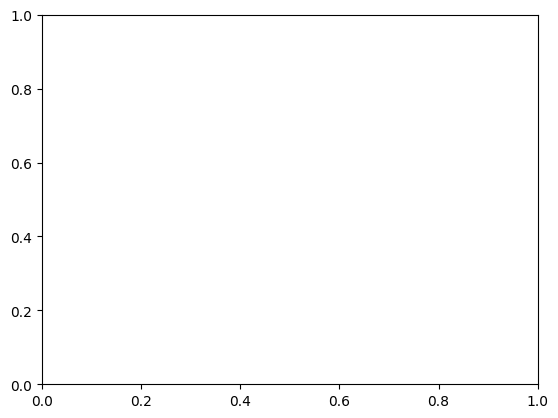

In [113]:
file1.plot()

In [112]:
file1.to_netcdf(cog_name)